In [14]:
import torch.nn.functional as F
import voc12.dataloader
import argparse
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
from misc import pyutils, torchutils, imutils
from net.resnet50_cam import Net, CAM
from torch import nn
from torchvision.transforms import transforms
from voc12.dataloader import get_img_path

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
train_list = '/Users/Andy/Projects/front_door_cam/voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'

train_dataset = voc12.dataloader.VOC12ClassificationDataset(train_list, voc12_root=voc12_root,
                                                            resize_long=(160, 320), hor_flip=True,
                                                            crop_size=256, crop_method="random")
train_data_loader = DataLoader(train_dataset,
                               batch_size=16,
                               shuffle=False,
                               num_workers=1,
                               pin_memory=True,
                               drop_last=True)


data_iter = iter(train_data_loader)
pack = next(data_iter)

In [3]:
m = Net()
m.load_state_dict(torch.load(os.path.join('/Users/Andy/Projects/resnet50_frontdoor_styleintervention.pth'), map_location='cpu'), strict=True)

<All keys matched successfully>

In [5]:
def plot_batch(names, voc12_root):
    w = 256
    h = 256
    fig = plt.figure(figsize=(16, 16))
    columns = 4
    rows = 4
    for i in range(1, columns * rows +1):
        im = Image.open(get_img_path(names[i-1], voc12_root)).convert('RGB')
        fig.add_subplot(rows, columns, i)
        plt.imshow(im)
        plt.title(names[i-1])
    plt.show()
    
def plot_prob(logits, labels):
    # plot
    x = np.arange(20)
    yp = F.softmax(logits, dim=1)
    n = logits.shape[0]
    columns = 4
    rows = 4
    index = 0
    fig, ax = plt.subplots(columns, rows, figsize=(16, 16))
    for i in np.arange(columns):
        for j in np.arange(rows):
            y = yp[index].squeeze().detach().numpy()  
            label = labels[index].numpy()
            color = np.asarray(['blue' for _ in range(20)])
            color[label == 1] = 'red'
            color = color.tolist()
            ax[i][j].bar(x, y, width=1, edgecolor="white", linewidth=0.7, color=color)
            ax[i][j].set(xlim=(0, 1), xticks=np.arange(20),
                   ylim=(0, 1))
            index += 1
    plt.show()

In [6]:
imgs = pack['img']
print(pack.keys())
names = pack['name']
print(imgs.shape)
labels = pack['label']
print(labels.shape)

dict_keys(['name', 'img', 'label'])
torch.Size([16, 3, 256, 256])
torch.Size([16, 20])


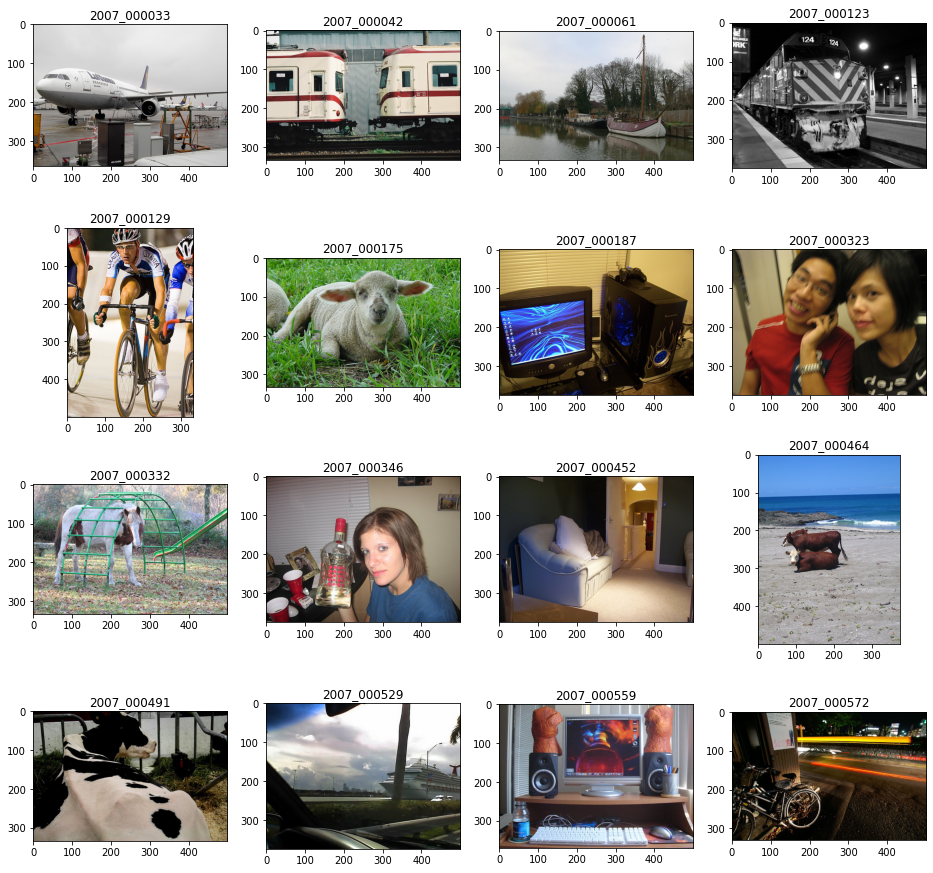

In [7]:
plot_batch(names, voc12_root)

In [8]:
print(imgs.shape)
logits = m(imgs)

torch.Size([16, 3, 256, 256])


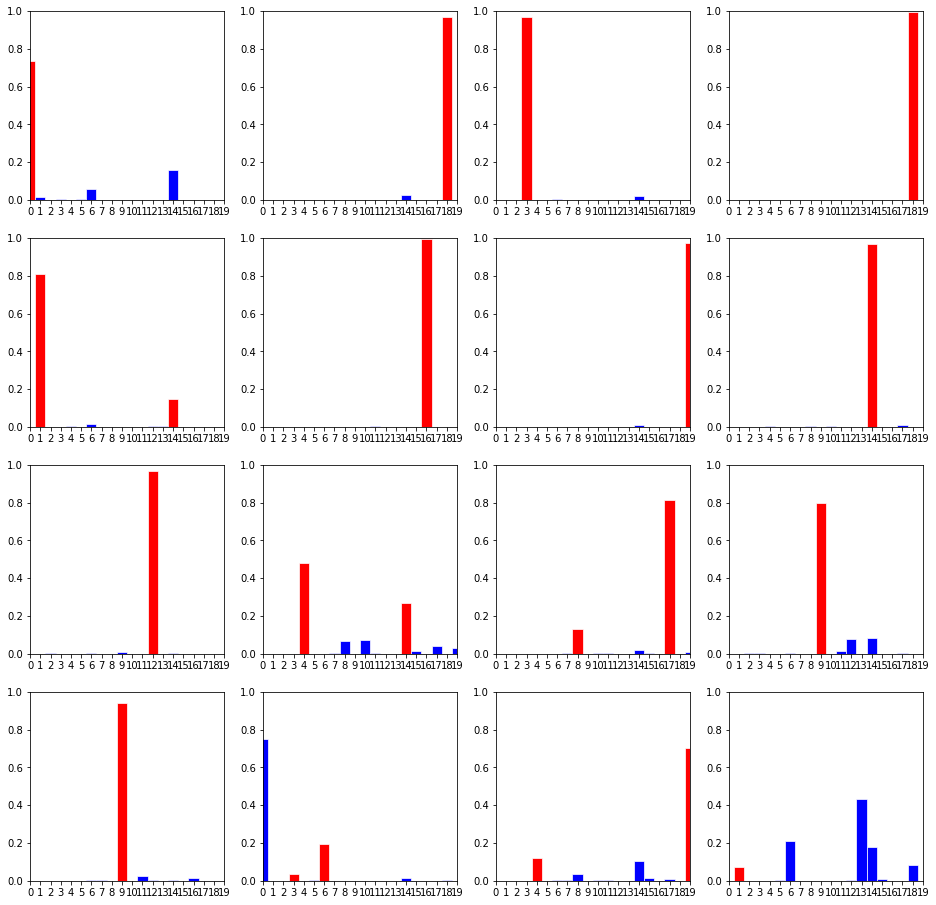

In [9]:
plot_prob(logits, labels)

In [12]:
# Inspect CAM

val_list = '/Users/Andy/Projects/front_door_cam/voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
frontdoor_cam_weight_path = '/Users/Andy/Projects/resnet50_frontdoor_styleintervention.pth'

val_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
data_loader = DataLoader(val_dataset, shuffle=False)

model_frontdoor = CAM()
model_frontdoor.eval()
model_frontdoor.load_state_dict(torch.load(frontdoor_cam_weight_path, map_location='cpu'))


<All keys matched successfully>

In [15]:
data_iter = iter(data_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']

    strided_up_size = imutils.get_strided_up_size(size, 16)

    frontdoor_outputs = [model_frontdoor(img[0]) for img in pack['img']]
    
    frontdoor_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in frontdoor_outputs]
    frontdoor_highres_cam = torch.sum(torch.stack(frontdoor_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]


    valid_cat = torch.nonzero(label)[:, 0]

    frontdoor_highres_cam = frontdoor_highres_cam[valid_cat]
    frontdoor_highres_cam /= F.adaptive_max_pool2d(frontdoor_highres_cam, (1, 1)) + 1e-5
    

print(frontdoor_highres_cam.min(), frontdoor_highres_cam.max())

/Users/Andy/Projects/front_door_cam/misc/imutils.py:174: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return ((orig_size[0]-1)//stride+1, (orig_size[1]-1)//stride+1)


tensor(0.0069) tensor(1.0000)


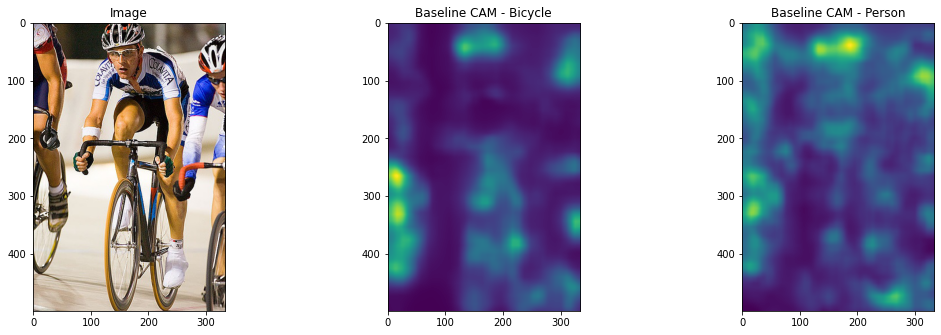

In [16]:
im = Image.open(os.path.join(voc12_root, 'JPEGImages', '2007_000129' + '.jpg'))

fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(331)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(332)
plt.title('Baseline CAM - Bicycle')
ax2.imshow(frontdoor_highres_cam[0].squeeze())
ax3 = fig.add_subplot(333)
plt.title('Baseline CAM - Person')
ax3.imshow(frontdoor_highres_cam[1].squeeze())